In [2]:
import komm
import numpy as np
import numpy as npt
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [11]:
# Parâmetros
n_ofdm = 128
n_cp = 32
n_seq = 1000
n_symbols = n_seq * n_ofdm
SNR = np.arange(-5, 25)

modulations = [
    komm.QAModulation(4),
    komm.QAModulation(16),
]

ber_mod = np.zeros((len(modulations), len(SNR)))

for i, mod in enumerate(modulations):
    s = np.random.randint(0, 2, n_symbols * int(np.log2(mod.order)))
    s_mod = mod.modulate(s)
    s_parallel = s_mod.reshape(n_ofdm, n_seq)
    s_ifft = ifft(s_parallel, axis=0)

    s_ofdm = np.zeros((n_ofdm + n_cp, n_seq), dtype=complex)  # Inicializa sinal OFDM
    s_ofdm[n_cp:] = s_ifft  # Insere o sinal IFFT
    s_ofdm[:n_cp] = s_ifft[-n_cp:]  # Adiciona o prefixo cíclico

    tx = s_ofdm.flatten()

    for j, snr in enumerate(SNR):
        awgn = komm.AWGNChannel(snr=10 ** (snr / 10), signal_power="measured")

        y_channel = awgn(tx)

        rx = y_channel.reshape(n_ofdm + n_cp, n_seq)
        rx_ofdm = rx[n_cp:]
        rx_fft = fft(rx_ofdm, axis=0)
        rx_seq = rx_fft.flatten()
        s_hat = mod.demodulate(rx_seq)

        ber_mod[i, j] = np.mean(s != s_hat)

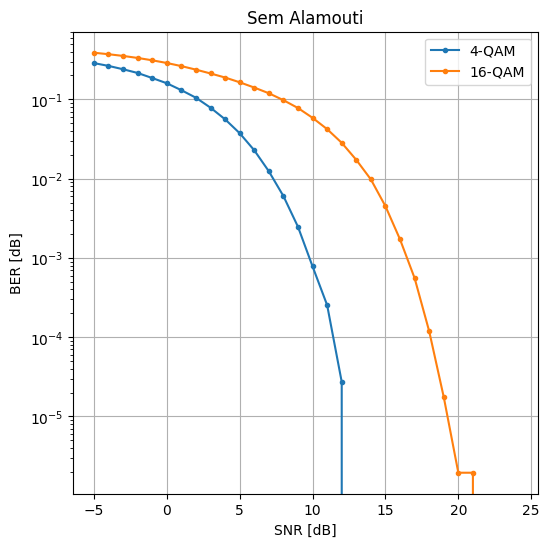

In [12]:
plt.figure(figsize=(6, 6))
plt.title("Sem Alamouti")

labels = ["4-QAM", "16-QAM"]

for row in range(ber_mod.shape[0]):
    plt.semilogy(SNR, ber_mod[row, :], label=labels[row], marker=".")

plt.legend()
plt.xlabel("SNR [dB]")
plt.ylabel("BER [dB]")
plt.grid(True)
plt.show()

In [57]:
# Parâmetros
n_ofdm = 128
n_cp = 32
n_seq = 1000
n_symbols = n_seq * n_ofdm
SNR = np.arange(-5, 25)

modulations = [
    komm.QAModulation(4),
    komm.QAModulation(16),
]

ber_mod_alamouti = np.zeros((len(modulations), len(SNR)))

for i, mod in enumerate(modulations):
    s1 = np.random.randint(0, 2, n_symbols * int(np.log2(mod.order)))
    s2 = np.random.randint(0, 2, n_symbols * int(np.log2(mod.order)))

    h1 = np.random.normal(0, 1 / np.sqrt(2)) + 1j * np.random.normal(0, 1 / np.sqrt(2))
    h2 = np.random.normal(0, 1 / np.sqrt(2)) + 1j * np.random.normal(0, 1 / np.sqrt(2))

    s1_ifft = ifft(mod.modulate(s1).reshape(n_ofdm, n_seq), axis=0)
    s1_ofdm = np.zeros((n_ofdm + n_cp, n_seq), dtype=complex)
    s1_ofdm[n_cp:] = s1_ifft
    s1_ofdm[:n_cp] = s1_ifft[-n_cp:]
    s1_ofdm = s1_ofdm.flatten()

    s2_ifft = ifft(mod.modulate(s2).reshape(n_ofdm, n_seq), axis=0)
    s2_ofdm = np.zeros((n_ofdm + n_cp, n_seq), dtype=complex)
    s2_ofdm[n_cp:] = s2_ifft
    s2_ofdm[:n_cp] = s2_ifft[-n_cp:]
    s2_ofdm = s2_ofdm.flatten()

    C = np.array(
        [
            [s1_ofdm, s2_ofdm],
            [-np.conj(s2_ofdm), np.conj(s1_ofdm)],
        ],
        dtype=complex,
    )

    C[:, 0] = C[:, 0] * h1
    C[:, 1] = C[:, 1] * h2
    for j, snr in enumerate(SNR):
        awgn = komm.AWGNChannel(snr=10 ** (snr / 10), signal_power="measured")

        r1 = awgn(C[0, :].sum(axis=0))
        r2 = awgn(C[1, :].sum(axis=0))

        y1 = np.conj(h1) * r1 + h2 * np.conj(r2)
        y2 = np.conj(h2) * r1 - h1 * np.conj(r2)

        s1_ofdm_hat = y1 / (np.abs(h1) ** 2 + np.abs(h2) ** 2)
        s2_ofdm_hat = y2 / (np.abs(h1) ** 2 + np.abs(h2) ** 2)

        s1_fft_hat = fft(s1_ofdm_hat.reshape(n_ofdm + n_cp, n_seq)[n_cp:], axis=0)
        s2_fft_hat = fft(s2_ofdm_hat.reshape(n_ofdm + n_cp, n_seq)[n_cp:], axis=0)

        s1_hat = mod.demodulate(s1_fft_hat.flatten())
        s2_hat = mod.demodulate(s2_fft_hat.flatten())

        ber_mod_alamouti[i, j] = (np.mean(s1 != s1_hat) + np.mean(s2 != s2_hat)) / 2

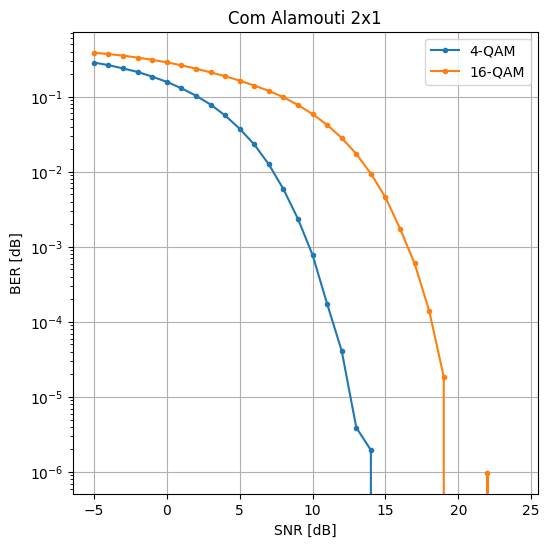

In [58]:
plt.figure(figsize=(6, 6))
plt.title("Com Alamouti 2x1")

labels = ["4-QAM", "16-QAM"]

for row in range(ber_mod.shape[0]):
    plt.semilogy(SNR, ber_mod_alamouti[row, :], label=labels[row], marker=".")

plt.legend()
plt.xlabel("SNR [dB]")
plt.ylabel("BER [dB]")
plt.grid(True)
plt.show()